In [1]:
# !pip install clearml

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=PASTE_KEY
%env CLEARML_API_SECRET_KEY=PASTE_KEY
%env CUDA_VISIBLE_DEVICES=2

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=
env: CLEARML_API_SECRET_KEY=
env: CUDA_VISIBLE_DEVICES=2


In [3]:
from clearml import Task, Logger

# Initialize ClearML Task
task = Task.init(
    project_name="VAE Experiments",
    task_name="VAE with KL vs Wasserstein Loss",
    task_type=Task.TaskTypes.training
)

ClearML Task: created new task id=1ee2da5430a5481d9c5000719ab8c7f1
2025-01-19 17:20:35,258 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/9f16ed557f8e430c9fbdc9fde5d73b30/experiments/1ee2da5430a5481d9c5000719ab8c7f1/output/log


In [4]:
# Log metrics and training progress
def log_metrics(epoch, train_loss, recon_loss, reg_loss, func):
    Logger.current_logger().report_scalar(f"Loss ({func})", "Total Loss", iteration=epoch, value=train_loss)
    Logger.current_logger().report_scalar(f"Loss ({func})", "Reconstruction Loss", iteration=epoch, value=recon_loss)
    Logger.current_logger().report_scalar(f"Loss ({func})", "Regularization Loss", iteration=epoch, value=reg_loss)

# **Experiment Description**

In this experiment, the goal is to compare the performance of a Variational Autoencoder (VAE) using two different loss functions: **KL divergence** and the **Wasserstein metric**.  

1. **Objective**:
   - Understand how the choice of the divergence/metric in the loss function affects the quality of latent representations and reconstructed data.
   - Compare the performance in terms of reconstruction quality, latent space structure, and generalization ability.

2. **Steps**:
   - **Implement a Simple VAE**:
     - Design a basic VAE architecture with fully connected layers for encoding and decoding.
     - Use a Gaussian prior for the latent space and a reparameterization trick for sampling.
   - **Train the VAE with KL Divergence**:
     - Use the KL divergence to regularize the latent space to match the prior distribution.
   - **Train the VAE with the Wasserstein Metric**:
     - Replace the KL divergence with the Wasserstein metric to regularize the latent space.
   - **Evaluate and Compare**:
     - Assess reconstruction quality using metrics like Mean Squared Error (MSE) on the test dataset.
     - Visualize the learned latent space for each loss function using 2D projections.
     - Compare training stability and convergence speed for both loss functions.

3. **Expected Outcome**:
   - The KL divergence is likely to yield good performance for Gaussian priors but may suffer from issues like posterior collapse.
   - The Wasserstein metric might provide smoother optimization and better latent space representations, especially if the data distribution differs significantly from the Gaussian prior.

By comparing the results, you’ll gain insights into the strengths and weaknesses of each approach in the context of VAEs.

___


### **1. What is a VAE?**
A VAE is a type of neural network used to generate data, such as images or text. It learns to compress input data into a **latent space** (a compact, lower-dimensional representation) and then reconstruct or generate new data from this latent space.

---

### **2. How Does It Work?**
VAEs consist of two main parts:

#### **a) Encoder**
- The encoder takes an input (e.g., an image) and compresses it into a **latent representation**.  
- Instead of producing a single point, the encoder outputs the **parameters of a probability distribution** in the latent space (mean $\mu$ and standard deviation $\sigma$).
- This means the latent space is a random variable, not a fixed value.  

#### **b) Decoder**
- The decoder takes a sample from the latent distribution and tries to reconstruct the original input from it.
- It learns to map points in the latent space back to the input space.

---

### **3. Why Use a Latent Distribution?**
Instead of just learning fixed points in the latent space, the VAE learns a **distribution** (e.g., a Gaussian) for each input. This has two advantages:
1. **Generative Capability:** By sampling from the latent distribution, the VAE can generate new data points that resemble the training data.
2. **Smooth Latent Space:** Close points in the latent space correspond to similar outputs, making it easier to interpolate between data points.

---

### **4. Loss Function**
The VAE is trained using two objectives:
1. **Reconstruction Loss:** Ensures the decoder reconstructs the input accurately. Typically, this is the mean squared error (for continuous data) or cross-entropy (for categorical data).
   $$
   \text{Reconstruction Loss} = \| x - \hat{x} \|^2
   $$

2. **KL Divergence:** Ensures the latent space follows a standard Gaussian distribution $\mathcal{N}(0, I)$. This regularizes the latent space and encourages smoothness.
   $$
   \text{KL Divergence} = D_{KL}(q(z|x) \,||\, p(z))
   $$

The total loss combines these two:
$$
\text{Total Loss} = \text{Reconstruction Loss} + \beta \cdot \text{KL Divergence}
$$
(where $\beta$ balances the two terms).

---

### **5. Training Process**
1. **Input to Latent Space:** The encoder takes an input $x$ and outputs $\mu(x)$ and $\sigma(x)$, the parameters of the latent distribution $q(z|x)$.
2. **Sampling (Reparameterization Trick):** A random sample $z$ is drawn from $q(z|x)$, using:
   $$
   z = \mu(x) + \sigma(x) \cdot \epsilon
   $$
   where $\epsilon \sim \mathcal{N}(0, I)$.
3. **Reconstruction:** The decoder uses $z$ to generate $\hat{x}$, the reconstruction of the input.
4. **Loss Minimization:** The loss (reconstruction + KL divergence) is minimized via gradient descent.

---

### **6. What Can VAEs Do?**
- **Data Generation:** VAEs can generate new data by sampling from the latent space and passing it through the decoder.
- **Interpolation:** Since the latent space is smooth, VAEs can interpolate between points, creating transitions between data samples (e.g., blending images).
- **Anomaly Detection:** VAEs can identify anomalies by measuring how well they can reconstruct inputs (poor reconstruction indicates unusual data).

---

### **Simple Analogy**
Think of the VAE like a painter:
1. The **encoder** describes an image by summarizing it into a set of instructions (latent distribution).
2. The **decoder** takes those instructions and tries to recreate the original image.
3. During training, the VAE learns to make its instructions compact and consistent while still being able to reconstruct accurately.

# **EXPERIMENT**

### VAE Architecture
A VAE consists of:
- **Encoder:** Maps input data to a latent distribution (mean and log-variance).
- **Latent Space Sampling:** Reparameterization trick for sampling latent vectors.
- **Decoder:** Reconstructs data from latent vectors.

In [5]:
import torch
from torch import nn
import os

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim * 2)  # Output both mean and log-variance
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # encoder pass
        h = self.encoder(x)

        # Attempts to split a tensor into the specified number of chunks. Each chunk is a view of the input tensor.
        mu, log_var = torch.chunk(h, 2, dim=-1) 
        
        # sampling
        z = self.reparameterize(mu, log_var)

        return self.decoder(z), mu, log_var


2025-01-19 17:20:40.566922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737296440.581019    5497 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737296440.585327    5497 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 17:20:40.603841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loss Functions

**KL Divergence Loss:**

In [6]:
def kl_divergence_loss(mu, log_var):
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

**Wasserstein Metric Loss:**

In [7]:
def wasserstein_loss(real, fake):
    return torch.mean(torch.abs(real - fake))  # Example metric

# Above, for simplicity, PyTorch's Sinkhorn distance is used. Normal loss function will be introduced later.

**Reconstruction Loss (common for both):**

In [8]:
def reconstruction_loss(recon_x, x):
    return nn.BCELoss(reduction='sum')(recon_x, x)

### Total Loss:

In [9]:
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = reconstruction_loss(recon_x, x)
    reg_loss = kl_divergence_loss(mu, log_var)
    return recon_loss + reg_loss

# Dataset

In [10]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

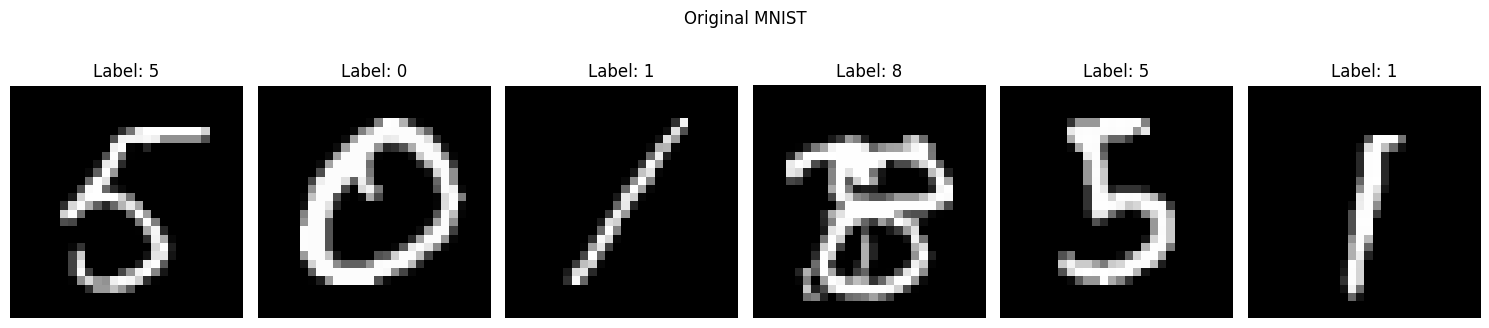

In [11]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Plot some examples from the dataset
fig, axes = plt.subplots(1, 6, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.suptitle("Original MNIST")
plt.show()

In [12]:
x = images[i]
print(x.shape)
print()
print(x.view(x.size(0), -1).shape)

torch.Size([1, 28, 28])

torch.Size([1, 784])


# Training with KL Divergence

In [13]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device = torch.device("cuda" if use_cuda else "mps" if use_mps else "cpu")
device

device(type='cuda')

In [14]:
from tqdm import tqdm

# Training Function
def train_vae(vae, data_loader, optimizer, epochs=10):
    vae.train()
    train_loss = []
    for epoch in range(epochs):
        total_loss, total_recon_loss, total_reg_loss = 0, 0, 0
        with tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for x, _ in pbar:
                x = x.view(x.size(0), -1).to(device)  # Flatten input
                optimizer.zero_grad()
                recon_x, mu, log_var = vae(x)

                loss = vae_loss(recon_x, x, mu, log_var)
                recon_loss = reconstruction_loss(recon_x, x).item()
                reg_loss = loss.item() - recon_loss  # Calculate regularization loss
                
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                total_recon_loss += recon_loss
                total_reg_loss += reg_loss
                pbar.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(data_loader.dataset)
        avg_recon_loss = total_recon_loss / len(data_loader.dataset)
        avg_reg_loss = total_reg_loss / len(data_loader.dataset)
        train_loss.append(avg_loss)

        # Log metrics to ClearML
        log_metrics(epoch + 1, avg_loss, avg_recon_loss, avg_reg_loss, "KL")

        print(f"Epoch {epoch+1}, Total Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, Reg Loss: {avg_reg_loss:.4f}")
        
    return train_loss

In [19]:
# Log hyperparameters
hyperparameters = {
    "input_dim": 28 * 28,  # Flattened MNIST images
    "latent_dim": 10,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "epochs": 35,
    "loss_type": "kl"  # Change to 'wasserstein' as needed
}
task.connect(hyperparameters)

# Model, Optimizer
vae = VAE(hyperparameters["input_dim"], hyperparameters["latent_dim"]).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=hyperparameters["learning_rate"])

In [20]:
# Save Model and Artifacts
def save_and_log_model(vae, model_name):
    model_path = f"weights/{model_name}.pth"
    torch.save(vae.state_dict(), model_path)
    task.upload_artifact(name=model_name, artifact_object=model_path)

In [ ]:
# # Train VAE
# if os.path.exists("weights/vae_kl_divergence.pth"):
#     state_dict = torch.load("weights/vae_kl_divergence.pth", map_location=device)
#     vae.load_state_dict(state_dict)
#     vae.eval()

/home/bot_env/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:277: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



2025-01-19 17:20:48,968 - clearml.model - INFO - Selected model id: 2495b5ce4e7448689c208182e0689951


# **EXECUTE CODE BELOW ONLY IF YOU WANT TO TRAIN MODEL**

Epoch 1/35: 100%|██████████| 938/938 [00:07<00:00, 129.34batch/s, loss=3.99e+3]


Epoch 1, Total Loss: 151.6978, Recon Loss: 136.7565, Reg Loss: 14.9413


Epoch 2/35: 100%|██████████| 938/938 [00:07<00:00, 119.89batch/s, loss=3.57e+3]


Epoch 2, Total Loss: 123.1423, Recon Loss: 106.3733, Reg Loss: 16.7691


Epoch 3/35: 100%|██████████| 938/938 [00:07<00:00, 133.59batch/s, loss=4.18e+3]


Epoch 3, Total Loss: 118.9925, Recon Loss: 101.7895, Reg Loss: 17.2030


Epoch 4/35: 100%|██████████| 938/938 [00:07<00:00, 124.65batch/s, loss=3.83e+3]


Epoch 4, Total Loss: 116.7896, Recon Loss: 99.3208, Reg Loss: 17.4688


Epoch 5/35: 100%|██████████| 938/938 [00:06<00:00, 134.71batch/s, loss=3.72e+3]


Epoch 5, Total Loss: 115.3106, Recon Loss: 97.6161, Reg Loss: 17.6945


Epoch 6/35: 100%|██████████| 938/938 [00:07<00:00, 129.39batch/s, loss=3.66e+3]


Epoch 6, Total Loss: 114.2376, Recon Loss: 96.3915, Reg Loss: 17.8461


Epoch 7/35: 100%|██████████| 938/938 [00:07<00:00, 132.17batch/s, loss=3.66e+3]


Epoch 7, Total Loss: 113.3947, Recon Loss: 95.4517, Reg Loss: 17.9430


Epoch 8/35: 100%|██████████| 938/938 [00:07<00:00, 126.63batch/s, loss=3.76e+3]


Epoch 8, Total Loss: 112.7113, Recon Loss: 94.6711, Reg Loss: 18.0402


Epoch 9/35: 100%|██████████| 938/938 [00:07<00:00, 121.31batch/s, loss=3.39e+3]


Epoch 9, Total Loss: 112.1494, Recon Loss: 94.0392, Reg Loss: 18.1102


Epoch 10/35: 100%|██████████| 938/938 [00:07<00:00, 125.12batch/s, loss=3.34e+3]


Epoch 10, Total Loss: 111.6640, Recon Loss: 93.4672, Reg Loss: 18.1968


Epoch 11/35: 100%|██████████| 938/938 [00:06<00:00, 134.02batch/s, loss=3.3e+3] 


Epoch 11, Total Loss: 111.2252, Recon Loss: 92.9716, Reg Loss: 18.2535


Epoch 12/35: 100%|██████████| 938/938 [00:07<00:00, 130.74batch/s, loss=3.5e+3] 


Epoch 12, Total Loss: 110.8488, Recon Loss: 92.5418, Reg Loss: 18.3070


Epoch 13/35: 100%|██████████| 938/938 [00:07<00:00, 129.26batch/s, loss=3.65e+3]


Epoch 13, Total Loss: 110.5230, Recon Loss: 92.1712, Reg Loss: 18.3519


Epoch 14/35: 100%|██████████| 938/938 [00:07<00:00, 125.08batch/s, loss=3.28e+3]


Epoch 14, Total Loss: 110.1789, Recon Loss: 91.8029, Reg Loss: 18.3760


Epoch 15/35: 100%|██████████| 938/938 [00:07<00:00, 126.39batch/s, loss=3.27e+3]


Epoch 15, Total Loss: 109.8966, Recon Loss: 91.4891, Reg Loss: 18.4075


Epoch 16/35: 100%|██████████| 938/938 [00:08<00:00, 117.05batch/s, loss=3.48e+3]


Epoch 16, Total Loss: 109.6299, Recon Loss: 91.1982, Reg Loss: 18.4318


Epoch 17/35: 100%|██████████| 938/938 [00:06<00:00, 137.28batch/s, loss=3.74e+3]


Epoch 17, Total Loss: 109.4054, Recon Loss: 90.9375, Reg Loss: 18.4679


Epoch 18/35: 100%|██████████| 938/938 [00:07<00:00, 125.03batch/s, loss=3.35e+3]


Epoch 18, Total Loss: 109.2008, Recon Loss: 90.6997, Reg Loss: 18.5011


Epoch 19/35: 100%|██████████| 938/938 [00:08<00:00, 114.55batch/s, loss=3.48e+3]


Epoch 19, Total Loss: 108.9745, Recon Loss: 90.4669, Reg Loss: 18.5076


Epoch 20/35: 100%|██████████| 938/938 [00:08<00:00, 113.02batch/s, loss=3.58e+3]


Epoch 20, Total Loss: 108.8033, Recon Loss: 90.2868, Reg Loss: 18.5165


Epoch 21/35: 100%|██████████| 938/938 [00:07<00:00, 121.73batch/s, loss=3.42e+3]


Epoch 21, Total Loss: 108.6573, Recon Loss: 90.0989, Reg Loss: 18.5584


Epoch 22/35: 100%|██████████| 938/938 [00:06<00:00, 136.62batch/s, loss=3.75e+3]


Epoch 22, Total Loss: 108.4530, Recon Loss: 89.8853, Reg Loss: 18.5678


Epoch 23/35: 100%|██████████| 938/938 [00:06<00:00, 136.83batch/s, loss=3.33e+3]


Epoch 23, Total Loss: 108.2991, Recon Loss: 89.7120, Reg Loss: 18.5871


Epoch 24/35: 100%|██████████| 938/938 [00:07<00:00, 124.51batch/s, loss=3.9e+3] 


Epoch 24, Total Loss: 108.1851, Recon Loss: 89.5956, Reg Loss: 18.5895


Epoch 25/35: 100%|██████████| 938/938 [00:07<00:00, 127.16batch/s, loss=3.33e+3]


Epoch 25, Total Loss: 108.0460, Recon Loss: 89.4301, Reg Loss: 18.6159


Epoch 26/35: 100%|██████████| 938/938 [00:07<00:00, 130.27batch/s, loss=3.47e+3]


Epoch 26, Total Loss: 107.9302, Recon Loss: 89.3188, Reg Loss: 18.6115


Epoch 27/35: 100%|██████████| 938/938 [00:06<00:00, 136.43batch/s, loss=3.38e+3]


Epoch 27, Total Loss: 107.7790, Recon Loss: 89.1498, Reg Loss: 18.6293


Epoch 28/35: 100%|██████████| 938/938 [00:06<00:00, 138.26batch/s, loss=3.38e+3]


Epoch 28, Total Loss: 107.6964, Recon Loss: 89.0565, Reg Loss: 18.6399


Epoch 29/35: 100%|██████████| 938/938 [00:06<00:00, 138.57batch/s, loss=3.44e+3]


Epoch 29, Total Loss: 107.5919, Recon Loss: 88.9292, Reg Loss: 18.6628


Epoch 30/35: 100%|██████████| 938/938 [00:06<00:00, 138.69batch/s, loss=3.54e+3]


Epoch 30, Total Loss: 107.5264, Recon Loss: 88.8347, Reg Loss: 18.6917


Epoch 31/35: 100%|██████████| 938/938 [00:06<00:00, 139.37batch/s, loss=3.09e+3]


Epoch 31, Total Loss: 107.3844, Recon Loss: 88.7270, Reg Loss: 18.6574


Epoch 32/35: 100%|██████████| 938/938 [00:06<00:00, 139.16batch/s, loss=3.29e+3]


Epoch 32, Total Loss: 107.2747, Recon Loss: 88.6103, Reg Loss: 18.6645


Epoch 33/35: 100%|██████████| 938/938 [00:07<00:00, 121.27batch/s, loss=3.27e+3]


Epoch 33, Total Loss: 107.2098, Recon Loss: 88.5320, Reg Loss: 18.6778


Epoch 34/35: 100%|██████████| 938/938 [00:07<00:00, 131.95batch/s, loss=3.58e+3]


Epoch 34, Total Loss: 107.1361, Recon Loss: 88.4403, Reg Loss: 18.6958


Epoch 35/35: 100%|██████████| 938/938 [00:07<00:00, 128.17batch/s, loss=3.49e+3]


Epoch 35, Total Loss: 107.0724, Recon Loss: 88.3630, Reg Loss: 18.7094


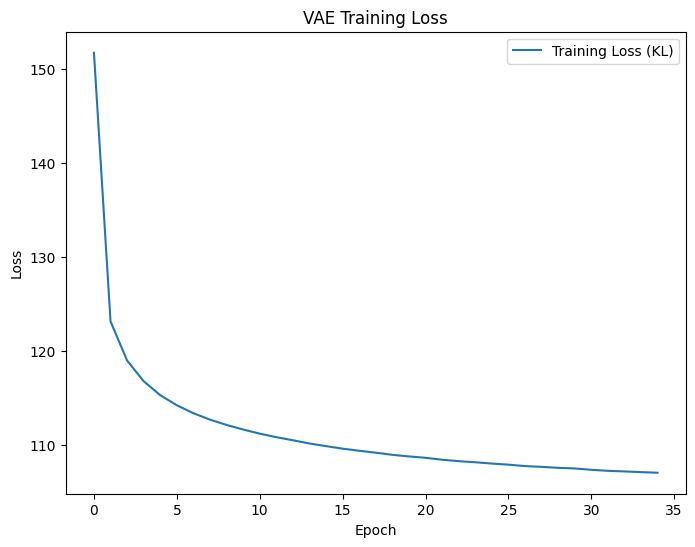

In [21]:
train_loss = train_vae(vae, train_loader, optimizer, hyperparameters["epochs"])
# Save and upload the trained model
save_and_log_model(vae, "vae_kl_divergence")


plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss (KL)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.savefig("training_loss.png")

# Plot Results

In [22]:
# Plot Results
def plot_results(vae, data_loader, num_samples=10, name="KL"):
    vae.eval()
    with torch.no_grad():
        # Get a batch of samples
        x, _ = next(iter(data_loader))
        x = x.view(x.size(0), -1).to(device)

        # Generate Reconstructions
        recon_x, _, _ = vae(x)

        # Plot Original and Reconstructed Images
        fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 2, 4))
        for i in range(num_samples):
            # Original images
            axes[0, i].imshow(x[i].cpu().view(28, 28), cmap='gray')
            axes[0, i].axis('off')
            # Reconstructed images
            axes[1, i].imshow(recon_x[i].cpu().view(28, 28), cmap='gray')
            axes[1, i].axis('off')
        axes[0, 0].set_ylabel("Original", fontsize=14)
        axes[1, 0].set_ylabel("Reconstructed", fontsize=14)
        plt.title(f"VAE Reconstructions with {name} in Loss F.")
        plt.show()

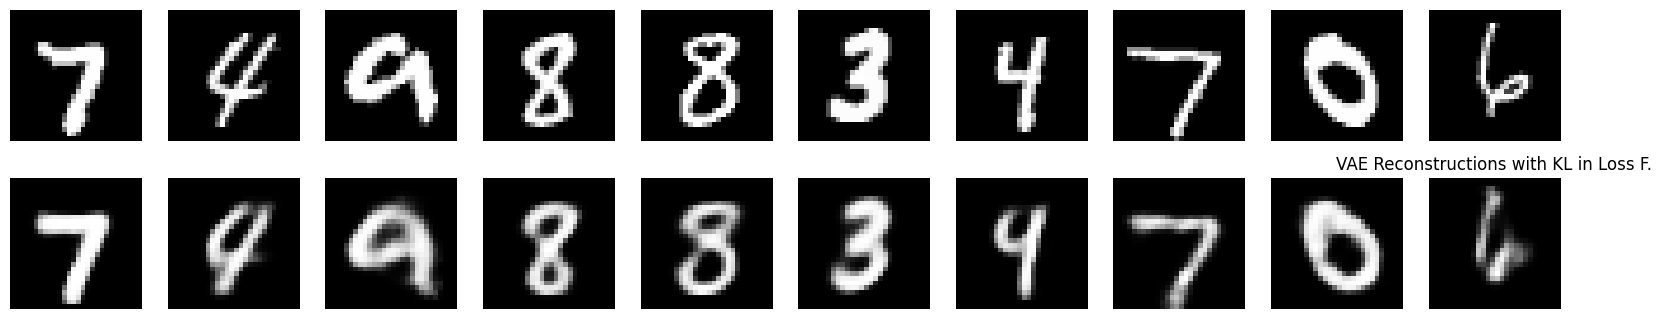

In [23]:
# Plot Reconstructions
plot_results(vae, train_loader)

In the plot above:
- **first row:** original image from MNIST
- **second row:** reconstructed image with VAE

In [24]:
from sklearn.manifold import TSNE

def plot_latent_space(vae, data_loader, name="KL"):
    vae.eval()
    with torch.no_grad():
        all_mu = []
        all_labels = []
        for x, y in data_loader:
            x = x.view(x.size(0), -1).to(device)
            _, mu, _ = vae(x)
            all_mu.append(mu.cpu())
            all_labels.append(y)
        
        all_mu = torch.cat(all_mu)
        all_labels = torch.cat(all_labels)

        # Dimensionality reduction
        
        reduced = TSNE(n_components=2).fit_transform(all_mu)

        # Plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, label="Digit Label")
        plt.title(f"VAE with {name} Latent Space Visualization (TSNE)")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        # plt.suptitle("VAE Latent Space with KL in Loss F.", fontsize=16)
        plt.show()


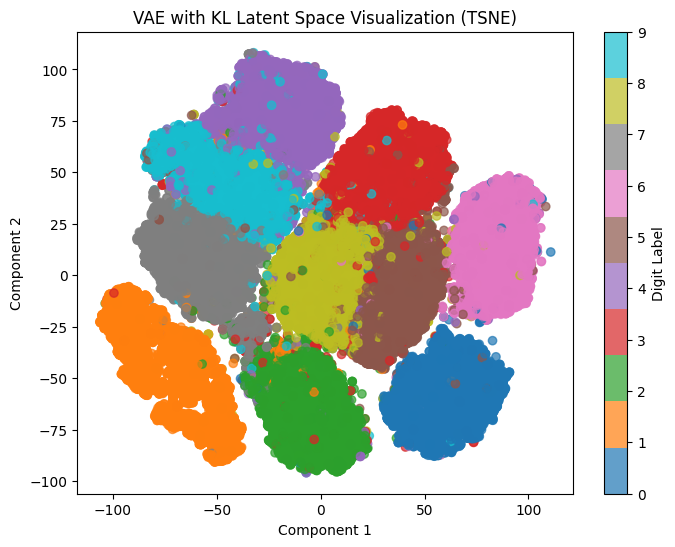

In [25]:
plot_latent_space(vae, train_loader)

In [26]:
import seaborn as sns

def plot_latent_distributions(vae, data_loader, name="KL"):
    vae.eval()
    with torch.no_grad():
        all_mu = []
        for x, _ in data_loader:
            x = x.view(x.size(0), -1).to(device)
            _, mu, _ = vae(x)
            all_mu.append(mu.cpu())
        all_mu = torch.cat(all_mu)

    # Plot distribution for each latent dimension
    num_latent_dims = all_mu.shape[1]
    fig, axes = plt.subplots(1, num_latent_dims, figsize=(num_latent_dims * 3, 4), sharey=True)
    for i in range(num_latent_dims):
        sns.kdeplot(all_mu[:, i], ax=axes[i], fill=True)
        axes[i].set_title(f"Latent Dim {i+1}")

    plt.suptitle(f"VAE Latent Distributions with {name} in Loss F.")
    plt.tight_layout()
    plt.show()


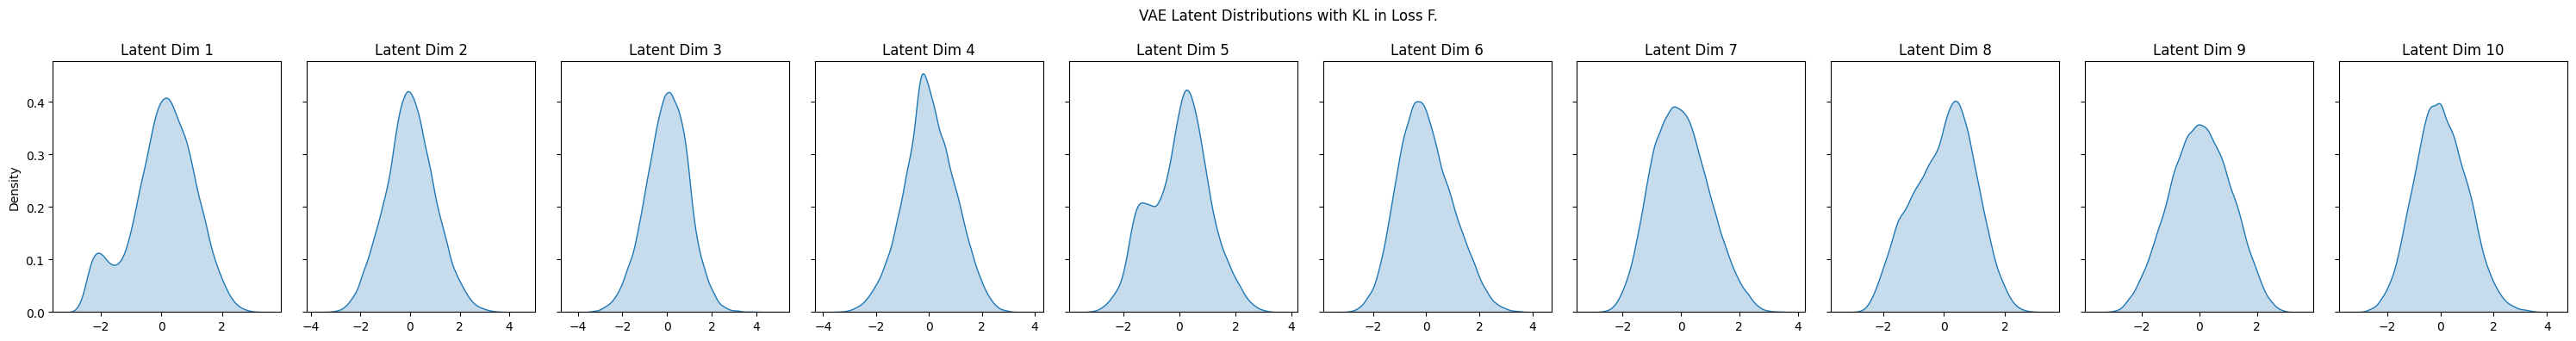

In [27]:
# This helps to see how well the latent space approximates a Gaussian distribution.
plot_latent_distributions(vae, train_loader)

In [28]:
def plot_interpolation(vae, data_loader, dim=0, num_steps=10, name="KL"):
    vae.eval()
    with torch.no_grad():
        # Get two random samples
        x, _ = next(iter(data_loader))
        x = x.view(x.size(0), -1).to(device)
        _, mu, _ = vae(x)

        # Select two points in the latent space
        z1, z2 = mu[0], mu[1]
        interpolation = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, num_steps)])

        # Decode interpolated points
        reconstructions = vae.decoder(interpolation)

        # Plot
        fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))
        for i in range(num_steps):
            axes[i].imshow(reconstructions[i].cpu().view(28, 28), cmap='gray')
            axes[i].axis('off')
        
        plt.suptitle(f"VAE with {name} interpolation")
        plt.show()

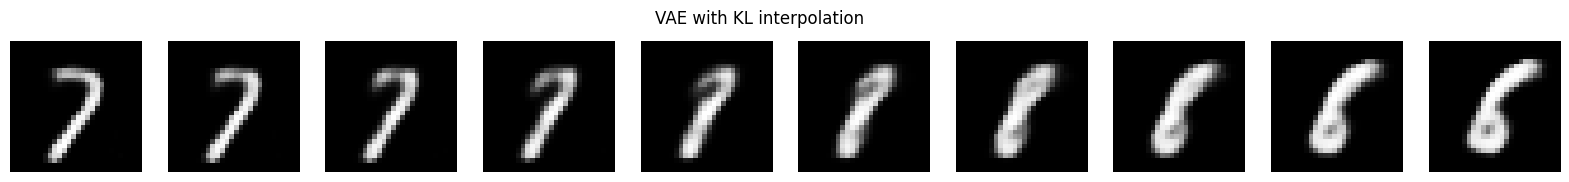

In [30]:
plot_interpolation(vae, train_loader, num_steps=10)

In [31]:
def plot_reconstruction_error(vae, data_loader, name="KL"):
    vae.eval()
    errors = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(x.size(0), -1).to(device)
            recon_x, _, _ = vae(x)
            error = ((x - recon_x) ** 2).sum(dim=1)
            errors.extend(error.cpu().numpy())
    
    # Plot histogram of reconstruction errors
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title(f"Reconstruction Error Distribution ({name})")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.show()

/home/bot_env/lib/python3.10/site-packages/clearml/utilities/plotlympl/renderer.py:210: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



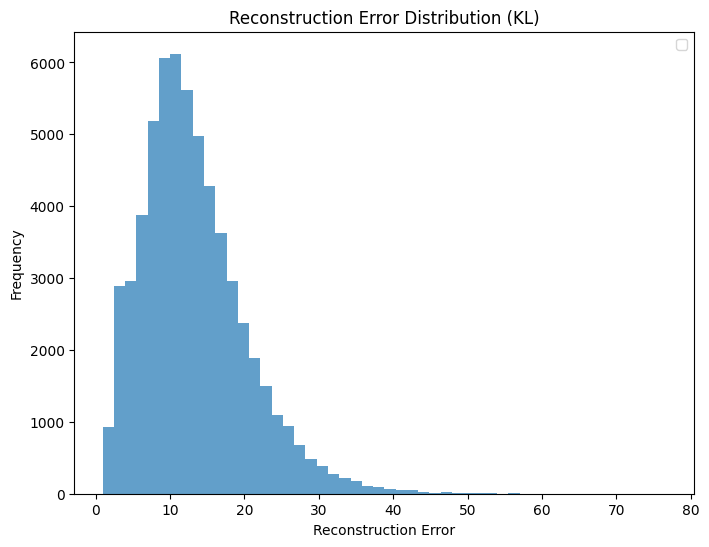

In [32]:
plot_reconstruction_error(vae, train_loader)

# **BEFORE YOU SAW THE ORIGINAL VAE WITH KL DIVERGENCE IN THE LOSS FUNCTUON**

NOW, LETS SEE WHAT WILL HAPPEN, IF WE USE WASSERSTEIN DISTANCE

# True Wasserstein loss

The Wasserstein loss isn't the same as the simple absolute difference metric I used as a placeholder before. Let’s dive deeper into the exact Wasserstein loss and its correct application.

The exact Wasserstein distance, however, is computationally expensive because it requires solving an optimization problem. Instead, **Wasserstein GANs (WGANs)** introduce the **Kantorovich-Rubinstein duality**, making it feasible to approximate Wasserstein distance efficiently by parameterizing the critic as a neural network.

### Correct Implementation of Wasserstein Loss in a VAE

Here’s how we can incorporate the Wasserstein loss correctly in a VAE:

1. **Latent Space Comparison**:
   - Instead of KL divergence between the latent distribution $q(z|x)$ and a prior distribution $p(z)$ (usually a standard Gaussian), we use the Wasserstein distance between these distributions.

2. **Dual Form Approximation**:
   - To approximate the Wasserstein distance, use a critic (discriminator-like network) that estimates the cost of transporting probability mass.

3. **Key Additions**:
   - Introduce a **critic network** $D(z)$ for the latent space.
   - Train the critic to maximize the difference between the real distribution $p(z)$ (e.g., standard Gaussian) and the generated distribution $q(z|x)$.

### Wasserstein Loss Implementation for VAE

Here’s how to adapt the VAE with Wasserstein loss:

In [47]:
# Define a simple fully connected network as the critic:
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increase hidden layer size
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )


    def forward(self, x):
        return self.model(x)


def wasserstein_loss_vae(critic, z_real, z_fake):
    """
    Wasserstein loss for the latent space.
    """
    real_score = critic(z_real)  # Critic output for real samples (from prior p(z))
    fake_score = critic(z_fake)  # Critic output for generated samples (from q(z|x))
    return torch.mean(fake_score) - torch.mean(real_score)  # W-distance approximation

'''
In Wasserstein GANs (WGANs), the discriminator (critic) must be 1-Lipschitz continuous 
to calculate the Wasserstein distance accurately. The Lipschitz constraint ensures that 
the critic does not "explode" and maintains meaningful gradients for optimization. This 
is crucial for stable training and meaningful results.
''' 

# To ensure the critic satisfies the Lipschitz constraint, add a gradient penalty:
def gradient_penalty(critic, z_real, z_fake):
    """
    Compute gradient penalty for Lipschitz constraint.
    """
    alpha = torch.rand(z_real.size(0), 1).to(z_real.device)
    z_interpolates = alpha * z_real + (1 - alpha) * z_fake 
    z_interpolates.requires_grad_(True)

    critic_scores = critic(z_interpolates)
    gradients = torch.autograd.grad(
        outputs=critic_scores,
        inputs=z_interpolates,
        grad_outputs=torch.ones_like(critic_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [65]:
# Training Function
def train_wvae(vae, critic, data_loader, vae_optimizer, critic_optimizer, epochs=10, gp_weight=10.0, critic_updates_per_step=5, recon_weight=0.5):
    vae.train()
    critic.train()

    for epoch in range(epochs):
        total_critic_loss = 0
        total_vae_loss, total_recon_loss, total_reg_loss = 0, 0, 0

        with tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for x, _ in pbar:
            
                x = x.view(x.size(0), -1).to(device)

                # Update Critic multiple times per VAE step
                for _ in range(critic_updates_per_step):
                    # Forward pass through VAE (detach z_fake for critic update)
                    recon_x, mu, log_var = vae(x)
                    z_fake = vae.reparameterize(mu, log_var).detach()

                    # Returns a tensor with the same size as input that is filled 
                    # with random numbers from a normal distribution with mean 0 and variance 1.
                    z_real = torch.randn_like(z_fake).to(device)  # Prior samples

                    # Critic loss
                    critic_optimizer.zero_grad()
                    w_loss = wasserstein_loss_vae(critic, z_real, z_fake)
                    gp = gradient_penalty(critic, z_real, z_fake)
                    critic_loss = w_loss + gp_weight * gp
                    critic_loss.backward()
                    critic_optimizer.step()

                    total_critic_loss += critic_loss.item()

                # Update VAE
                vae_optimizer.zero_grad()
                
                recon_loss = recon_weight * reconstruction_loss(recon_x, x)
                total_recon_loss += recon_loss

                z_fake = vae.reparameterize(mu, log_var)  # Recompute z_fake for VAE update
                z_real = torch.rand_like(z_fake).to(device)
                w_loss_vae = -100.0 * wasserstein_loss_vae(critic, z_real, z_fake)
                
                total_reg_loss += w_loss_vae


                vae_loss = recon_loss + w_loss_vae
                vae_loss.backward()
                vae_optimizer.step()

                total_vae_loss += vae_loss.item()
                pbar.set_postfix(loss=vae_loss.item())

        avg_loss = total_vae_loss / len(data_loader.dataset)
        avg_recon_loss = total_recon_loss / len(data_loader.dataset)
        avg_reg_loss = total_reg_loss / len(data_loader.dataset)

        log_metrics(epoch + 1, avg_loss, avg_recon_loss, avg_reg_loss, "Wass")
        
        print(
            f"Epoch {epoch + 1}, Critic Loss: {total_critic_loss / len(data_loader):.4f}, "
            f"VAE Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, Reg Loss: {avg_reg_loss:.4f}"
        )

In [66]:
hyperparameters_wass = {
    "input_dim": 28 * 28,  # Flattened MNIST images
    "latent_dim": 10,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "epochs": 35,
    "loss_type": "wasserstein",  # Change to 'wasserstein' as needed
    "gp_weight": 5.0,
    "recon_weight_wass": 0.9,
    "critic_updates_per_step_wass": 6
}
task.connect(hyperparameters_wass)

# Model, Optimizers
vae2 = VAE(hyperparameters_wass["input_dim"], 
           hyperparameters_wass["latent_dim"]
           ).to(device)
critic = Critic(hyperparameters_wass["latent_dim"]).to(device)
vae2_optimizer = torch.optim.Adam(vae2.parameters(), lr=hyperparameters_wass["learning_rate"])
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=hyperparameters_wass["learning_rate"])

In [ ]:
# if os.path.exists("weights/vae_wass_disrance.pth"):
#     state_dict = torch.load("weights/vae_wass_disrance.pth", map_location=device)
#     vae2.load_state_dict(state_dict)
#     vae2.eval()

# if os.path.exists("weights/critic.pth"):
#     state_dict = torch.load("weights/critic.pth", map_location=device)
#     critic.load_state_dict(state_dict)
#     critic.eval()

/home/bot_env/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:277: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



2025-01-19 17:05:22,702 - clearml.model - WARNING - Connecting multiple input models with the same name: `critic`. This might result in the wrong model being used when executing remotely


# **EXECUTE CODE BELOW ONLY IF YOU WANT TRAIN MODEL**

In [67]:
# Train W-VAE
train_wvae(vae2,
          critic, 
          train_loader, 
          vae2_optimizer, 
          critic_optimizer, 
          hyperparameters_wass["epochs"], 
          hyperparameters_wass["gp_weight"],
          hyperparameters_wass["critic_updates_per_step_wass"],
          hyperparameters_wass["recon_weight_wass"]
          )

save_and_log_model(vae2, "vae_wass_distance")
save_and_log_model(critic, "critic")

Epoch 1/35: 100%|██████████| 938/938 [00:24<00:00, 37.89batch/s, loss=2.87e+3]


Epoch 1, Critic Loss: -5.6419, VAE Loss: 116.9524, Recon Loss: 115.2509, Reg Loss: 1.7014


Epoch 2/35: 100%|██████████| 938/938 [00:24<00:00, 38.12batch/s, loss=2.98e+3]


Epoch 2, Critic Loss: -4.9796, VAE Loss: 89.4394, Recon Loss: 87.8981, Reg Loss: 1.5414


Epoch 3/35: 100%|██████████| 938/938 [00:24<00:00, 38.07batch/s, loss=2.66e+3]


Epoch 3, Critic Loss: -4.5815, VAE Loss: 85.4934, Recon Loss: 84.0617, Reg Loss: 1.4317


Epoch 4/35: 100%|██████████| 938/938 [00:25<00:00, 36.77batch/s, loss=2.53e+3]


Epoch 4, Critic Loss: -4.2671, VAE Loss: 83.1917, Recon Loss: 81.8497, Reg Loss: 1.3419


Epoch 5/35: 100%|██████████| 938/938 [00:24<00:00, 37.76batch/s, loss=2.66e+3]


Epoch 5, Critic Loss: -3.9854, VAE Loss: 81.6222, Recon Loss: 80.3570, Reg Loss: 1.2652


Epoch 6/35: 100%|██████████| 938/938 [00:24<00:00, 38.07batch/s, loss=2.56e+3]


Epoch 6, Critic Loss: -3.7513, VAE Loss: 80.4465, Recon Loss: 79.2480, Reg Loss: 1.1985


Epoch 7/35: 100%|██████████| 938/938 [00:24<00:00, 38.27batch/s, loss=2.56e+3]


Epoch 7, Critic Loss: -3.5434, VAE Loss: 79.5265, Recon Loss: 78.3861, Reg Loss: 1.1404


Epoch 8/35: 100%|██████████| 938/938 [00:26<00:00, 35.39batch/s, loss=2.65e+3]


Epoch 8, Critic Loss: -3.3605, VAE Loss: 78.7564, Recon Loss: 77.6683, Reg Loss: 1.0881


Epoch 9/35: 100%|██████████| 938/938 [00:38<00:00, 24.61batch/s, loss=2.45e+3]


Epoch 9, Critic Loss: -3.2005, VAE Loss: 78.1346, Recon Loss: 77.0929, Reg Loss: 1.0417


Epoch 10/35: 100%|██████████| 938/938 [00:43<00:00, 21.50batch/s, loss=2.81e+3]


Epoch 10, Critic Loss: -3.0608, VAE Loss: 77.6100, Recon Loss: 76.6067, Reg Loss: 1.0033


Epoch 11/35: 100%|██████████| 938/938 [00:30<00:00, 30.83batch/s, loss=2.44e+3]


Epoch 11, Critic Loss: -2.9365, VAE Loss: 77.1523, Recon Loss: 76.1858, Reg Loss: 0.9665


Epoch 12/35: 100%|██████████| 938/938 [00:24<00:00, 38.15batch/s, loss=2.6e+3] 


Epoch 12, Critic Loss: -2.8175, VAE Loss: 76.7443, Recon Loss: 75.8127, Reg Loss: 0.9316


Epoch 13/35: 100%|██████████| 938/938 [00:40<00:00, 23.33batch/s, loss=2.69e+3]


Epoch 13, Critic Loss: -2.7058, VAE Loss: 76.3716, Recon Loss: 75.4724, Reg Loss: 0.8992


Epoch 14/35: 100%|██████████| 938/938 [00:32<00:00, 29.15batch/s, loss=2.37e+3]


Epoch 14, Critic Loss: -2.6117, VAE Loss: 76.0602, Recon Loss: 75.1871, Reg Loss: 0.8731


Epoch 15/35: 100%|██████████| 938/938 [00:24<00:00, 38.19batch/s, loss=2.5e+3] 


Epoch 15, Critic Loss: -2.5163, VAE Loss: 75.7862, Recon Loss: 74.9408, Reg Loss: 0.8455


Epoch 16/35: 100%|██████████| 938/938 [00:28<00:00, 32.37batch/s, loss=2.46e+3]


Epoch 16, Critic Loss: -2.4265, VAE Loss: 75.5189, Recon Loss: 74.7010, Reg Loss: 0.8178


Epoch 17/35: 100%|██████████| 938/938 [00:24<00:00, 37.85batch/s, loss=2.42e+3]


Epoch 17, Critic Loss: -2.3420, VAE Loss: 75.2971, Recon Loss: 74.4968, Reg Loss: 0.8004


Epoch 18/35: 100%|██████████| 938/938 [00:32<00:00, 29.10batch/s, loss=2.29e+3]


Epoch 18, Critic Loss: -2.2669, VAE Loss: 75.0893, Recon Loss: 74.3090, Reg Loss: 0.7803


Epoch 19/35: 100%|██████████| 938/938 [00:41<00:00, 22.68batch/s, loss=2.71e+3]


Epoch 19, Critic Loss: -2.1962, VAE Loss: 74.8983, Recon Loss: 74.1364, Reg Loss: 0.7619


Epoch 20/35: 100%|██████████| 938/938 [00:46<00:00, 20.19batch/s, loss=2.34e+3]


Epoch 20, Critic Loss: -2.1278, VAE Loss: 74.7181, Recon Loss: 73.9793, Reg Loss: 0.7388


Epoch 21/35: 100%|██████████| 938/938 [00:24<00:00, 37.83batch/s, loss=2.46e+3]


Epoch 21, Critic Loss: -2.0664, VAE Loss: 74.5586, Recon Loss: 73.8373, Reg Loss: 0.7212


Epoch 22/35: 100%|██████████| 938/938 [00:24<00:00, 37.73batch/s, loss=2.44e+3]


Epoch 22, Critic Loss: -2.0021, VAE Loss: 74.4033, Recon Loss: 73.7002, Reg Loss: 0.7031


Epoch 23/35: 100%|██████████| 938/938 [00:33<00:00, 28.40batch/s, loss=2.37e+3]


Epoch 23, Critic Loss: -1.9464, VAE Loss: 74.2569, Recon Loss: 73.5705, Reg Loss: 0.6863


Epoch 24/35: 100%|██████████| 938/938 [00:26<00:00, 34.90batch/s, loss=2.65e+3]


Epoch 24, Critic Loss: -1.8980, VAE Loss: 74.1123, Recon Loss: 73.4418, Reg Loss: 0.6705


Epoch 25/35: 100%|██████████| 938/938 [00:25<00:00, 36.89batch/s, loss=2.44e+3]


Epoch 25, Critic Loss: -1.8501, VAE Loss: 73.9877, Recon Loss: 73.3303, Reg Loss: 0.6575


Epoch 26/35: 100%|██████████| 938/938 [00:47<00:00, 19.83batch/s, loss=2.36e+3]


Epoch 26, Critic Loss: -1.8022, VAE Loss: 73.8696, Recon Loss: 73.2268, Reg Loss: 0.6428


Epoch 27/35: 100%|██████████| 938/938 [00:24<00:00, 37.88batch/s, loss=2.38e+3]


Epoch 27, Critic Loss: -1.7585, VAE Loss: 73.7485, Recon Loss: 73.1192, Reg Loss: 0.6293


Epoch 28/35: 100%|██████████| 938/938 [00:24<00:00, 38.21batch/s, loss=2.39e+3]


Epoch 28, Critic Loss: -1.7182, VAE Loss: 73.6422, Recon Loss: 73.0295, Reg Loss: 0.6128


Epoch 29/35: 100%|██████████| 938/938 [00:24<00:00, 38.12batch/s, loss=2.45e+3]


Epoch 29, Critic Loss: -1.6764, VAE Loss: 73.5474, Recon Loss: 72.9431, Reg Loss: 0.6042


Epoch 30/35: 100%|██████████| 938/938 [00:24<00:00, 38.12batch/s, loss=2.44e+3]


Epoch 30, Critic Loss: -1.6440, VAE Loss: 73.4439, Recon Loss: 72.8505, Reg Loss: 0.5934


Epoch 31/35: 100%|██████████| 938/938 [00:24<00:00, 38.07batch/s, loss=2.35e+3]


Epoch 31, Critic Loss: -1.6104, VAE Loss: 73.3552, Recon Loss: 72.7762, Reg Loss: 0.5790


Epoch 32/35: 100%|██████████| 938/938 [00:24<00:00, 38.19batch/s, loss=2.35e+3]


Epoch 32, Critic Loss: -1.5757, VAE Loss: 73.2799, Recon Loss: 72.7093, Reg Loss: 0.5706


Epoch 33/35: 100%|██████████| 938/938 [00:24<00:00, 38.17batch/s, loss=2.42e+3]


Epoch 33, Critic Loss: -1.5409, VAE Loss: 73.2064, Recon Loss: 72.6414, Reg Loss: 0.5649


Epoch 34/35: 100%|██████████| 938/938 [00:24<00:00, 38.09batch/s, loss=2.2e+3] 


Epoch 34, Critic Loss: -1.5097, VAE Loss: 73.1348, Recon Loss: 72.5809, Reg Loss: 0.5539


Epoch 35/35: 100%|██████████| 938/938 [00:24<00:00, 38.18batch/s, loss=2.1e+3] 


Epoch 35, Critic Loss: -1.4772, VAE Loss: 73.0538, Recon Loss: 72.5112, Reg Loss: 0.5425


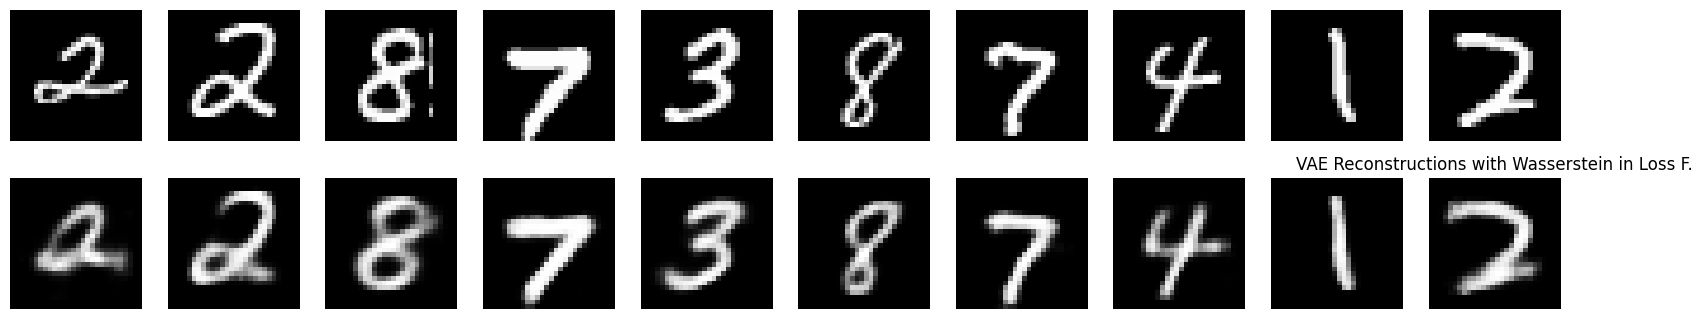

In [69]:
plot_results(vae2, train_loader, name="Wasserstein")

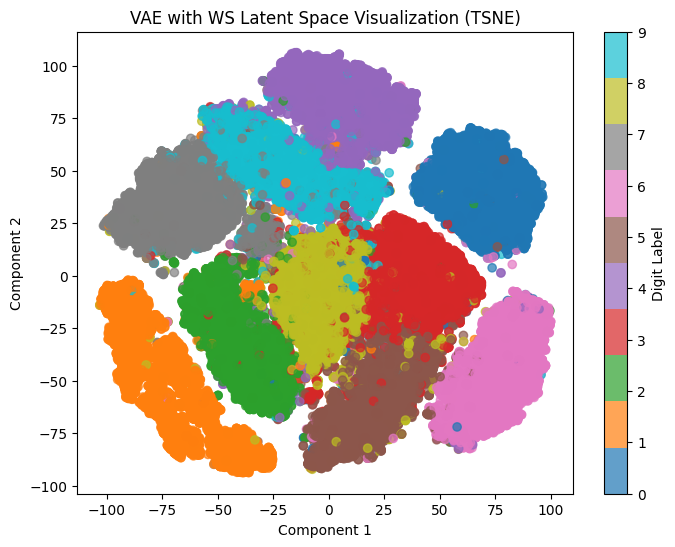

In [70]:
plot_latent_space(vae2, train_loader, name="WS")

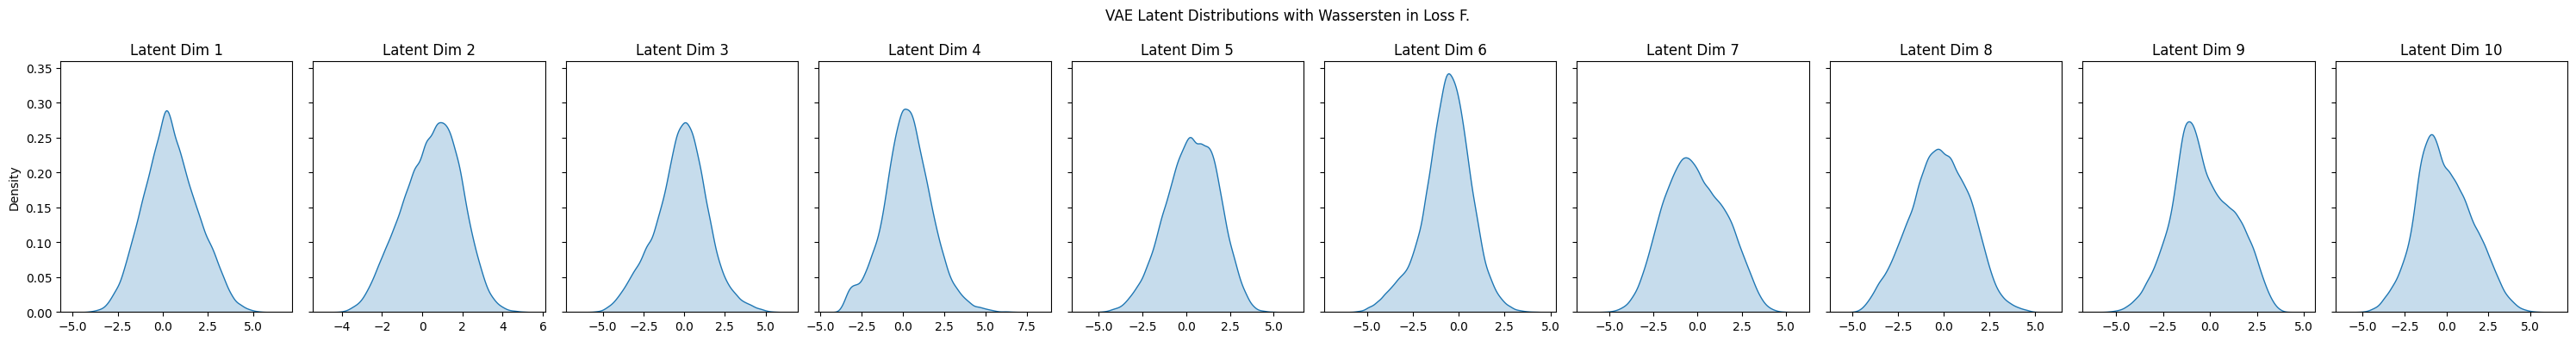

In [71]:
# This helps to see how well the latent space approximates a Gaussian distribution.
plot_latent_distributions(vae2, train_loader, name="Wassersten")

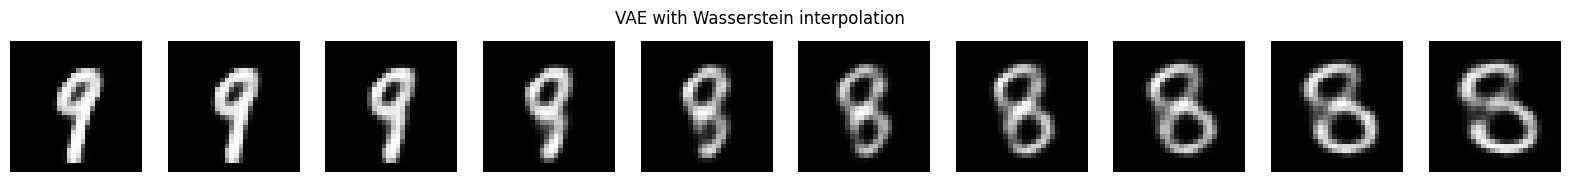

In [72]:
plot_interpolation(vae2, train_loader, num_steps=10, name="Wasserstein")

/home/bot_env/lib/python3.10/site-packages/clearml/utilities/plotlympl/renderer.py:210: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



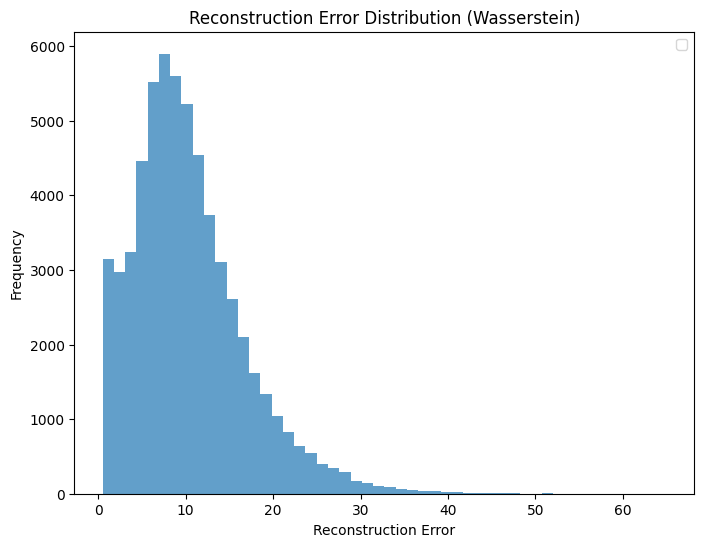

In [73]:
plot_reconstruction_error(vae2, train_loader, name="Wasserstein")